##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Supervised Learning (Classification) with TFP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/deep_exponential_family_with_tfp.ipynb"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/deep_exponential_family_with_tfp.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>


Original content [this Repository](https://github.com/blei-lab/edward/blob/master/notebooks/supervised_classification.ipynb), created by [the Blei Lab](http://www.cs.columbia.edu/~blei/)

Ported to [Tensorflow Probability](https://www.tensorflow.org/probability/) by Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)), with help from Bryan Seybold, Mike Shwe ([`@mikeshwe`](https://twitter.com/mikeshwe)), Josh Dillon, and the rest of the TFP team at  Google ([`tfprobability@tensorflow.org`](mailto:tfprobability@tensorflow.org)).

---

- [Dependencies & Prerequisites](#scrollTo=nvFPAsJ-bfth)
- [Introduction](#scrollTo=rLgn7MGNVLk-)
- [Data](#scrollTo=rETRud5cRm8q)
- [Model](#scrollTo=cfs4k7_gRm8u)
- [Inference](#scrollTo=w5bmYxs5Rm8x)
- [References](#scrollTo=PAs0LelnRm84)

## Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>. 
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent nightly installation: <code>pip3 install -q tfp-nightly</code></li>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
    <li> For the most recent nightly GPU-connected version of TFP: <code>pip3 install -q tfp-nightly-gpu</code></li>
    </ul>
Again, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [0]:
#@title Imports and Global Variables  { display-mode: "form" }
!pip install -q observations
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import string
from datetime import datetime
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
  try:
    tf.enable_eager_execution()
  except:
    pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
  """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
  Args:
  tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
    `namedtuple` or combinations thereof.
 
  Returns:
    ndarrays: Object with same structure as `tensors` except with `Tensor` or
      `EagerTensor`s replaced by Numpy `ndarray`s.
  """
  if tf.executing_eagerly():
    return tf.contrib.framework.nest.pack_sequence_as(
        tensors,
        [t.numpy() if tf.contrib.framework.is_tensor(t) else t
         for t in tf.contrib.framework.nest.flatten(tensors)])
  return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

## from edward.models import Bernoulli, MultivariateNormalTriL, Normal
# from edward.util import rbf
from observations import crabs


## Introduction

In supervised learning, the task is to infer hidden structure from labeled data, comprised of training examples $\{(x_n, y_n)\}$. Classification means the output $y$ takes discrete values.

## Data

Use the
[crabs data set](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/crabs.html),
which consists of morphological measurements on a crab species. We
are interested in predicting whether a given crab has the color form
blue (encoded as 0) or orange (encoded as 1). We use all the numeric features
in the dataset.

In [0]:
#@title Model Data Sources
# Set seed. Remove this line to generate different mixtures!
tf.set_random_seed(77)

data, metadata = crabs("~/data") #@param {type:"raw"}
X_train = data[:100, 3:] #@param {type:"raw"}
y_train = data[:100, 1]  #@param {type:"raw"}

N = X_train.shape[0]  # number of data points
D = X_train.shape[1]  # number of features

print("\nNumber of data points: {}".format(N))
print("Number of features: {}".format(D))


Number of data points: 100
Number of features: 5


## Model

A Gaussian process is a powerful object for modeling nonlinear
relationships between pairs of random variables. It defines a distribution over
(possibly nonlinear) functions, which can be applied for representing
our uncertainty around the true functional relationship.
Here we define a Gaussian process model for classification
(Rasumussen & Williams, 2006).

Formally, a distribution over functions $f:\mathbb{R}^D\to\mathbb{R}$ can be specified
by a Gaussian process
$$
\begin{align*}
  p(f)
  &=
  \mathcal{GP}(f\mid \mathbf{0}, k(\mathbf{x}, \mathbf{x}^\prime)),
\end{align*}
$$
whose mean function is the zero function, and whose covariance
function is some kernel which describes dependence between
any set of inputs to the function.

Given a set of input-output pairs
$\{\mathbf{x}_n\in\mathbb{R}^D,y_n\in\mathbb{R}\}$,
the likelihood can be written as a multivariate normal

\begin{align*}
  p(\mathbf{y})
  &=
  \text{Normal}(\mathbf{y} \mid \mathbf{0}, \mathbf{K})
\end{align*}

where $\mathbf{K}$ is a covariance matrix given by evaluating
$k(\mathbf{x}_n, \mathbf{x}_m)$ for each pair of inputs in the data
set.

The above applies directly for regression where $\mathbb{y}$ is a
real-valued response, but not for (binary) classification, where $\mathbb{y}$
is a label in $\{0,1\}$. To deal with classification, we interpret the
response as latent variables which is squashed into $[0,1]$. We then
draw from a Bernoulli to determine the label, with probability given
by the squashed value.

Define the likelihood of an observation $(\mathbf{x}_n, y_n)$ as

\begin{align*}
  p(y_n \mid \mathbf{z}, x_n)
  &=
  \text{Bernoulli}(y_n \mid \text{logit}^{-1}(\mathbf{x}_n^\top \mathbf{z})).
\end{align*}

Define the prior to be a multivariate normal

\begin{align*}
  p(\mathbf{z})
  &=
  \text{Normal}(\mathbf{z} \mid \mathbf{0}, \mathbf{K}),
\end{align*}

with covariance matrix given as previously stated.

Let's build the model in Edward. We use a radial basis function (RBF)
kernel, also known as the squared exponential or exponentiated
quadratic. It returns the kernel matrix evaluated over all pairs of
data points; we then Cholesky decompose the matrix to parameterize the
multivariate normal distribution.

### Radial basis function definition

The Radial basis function kernel, also known as the squared exponential or exponentiated quadratic, is defined as follows:

$k(x, x') = \sigma^2 \exp\Big(-\ \frac{1}{2} \sum_{d=1}^D \ \frac{1}{\ell_d^2} (x_d - x'_d)^2 \Big)$ for output variance $\sigma^2$ and lengthscale $\ell^2$.
  
The kernel is evaluated over all pairs of rows, `k(X[i, ], X2[j, ])`. If `X2` is not specified, then it evaluates over all pairs
  of rows in `X`, `k(X[i, ], X[j, ])`. The output is a matrix
  where each entry (`i`, `j`) is the kernel over the `i`th and `j`th rows.
  
An example of how we use this might look like the following:
```python
X = tf.random_normal([100, 5])
K = rbf(X)
assert K.shape == (100, 100)
```

In [0]:
def rbf(X, X2=None, lengthscale=1.0, variance=1.0):
    """Radial basis function kernel
    Args:
        X: tf.Tensor.
           N x D matrix of N data points each with D features.
        X2: tf.Tensor.
           N x D matrix of N data points each with D features.
        lengthscale: tf.Tensor.
           Lengthscale parameter, a positive scalar or D-dimensional vector.
        variance: tf.Tensor.
           Output variance parameter, a positive scalar.

    """
    lengthscale = tf.convert_to_tensor(lengthscale)
    variance = tf.convert_to_tensor(variance)
    dependencies = [tf.assert_positive(lengthscale),
                    tf.assert_positive(variance)]
    lengthscale = control_flow_ops.with_dependencies(dependencies, lengthscale)
    variance = control_flow_ops.with_dependencies(dependencies, variance)

    X = tf.convert_to_tensor(X)
    X = X / lengthscale
    Xs = tf.reduce_sum(tf.square(X), 1)
    if X2 is None:
        X2 = X
        X2s = Xs
    else:
        X2 = tf.convert_to_tensor(X2)
        X2 = X2 / lengthscale
        X2s = tf.reduce_sum(tf.square(X2), 1)

    square = tf.reshape(Xs, [-1, 1]) + tf.reshape(X2s, [1, -1]) - \
        2 * tf.matmul(X, X2, transpose_b=True)
    output = variance * tf.exp(-square / 2)
    return output


X = tf.to_float(X_train, name='X_train')

# Creating our Covariance Matrix and Mulvitariate Normal Distribution
f = tfd.MultivariateNormalTriL(loc=tf.zeros(N), scale_tril=tf.cholesky(rbf(X)))

# Feeding the latent function into a Poisson Distribution
x_init = tfd.Bernoulli(logits=tf.transpose(f.sample()))
y = tfd.Bernoulli(logits=tf.transpose(f.sample()))

# Getting our initial parametrization tensor for setting up the 
# trainable_distribution
x_ = evaluate(tf.transpose(x_init.sample(100)))


Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to data.

## Inference

We will perform variational inference. Our variational model will be defined to be a trainable multivariate normal. First, we need to set up the components of our `tfd.MultivariateNormalTriL` distribution, namely the functions for converting scalars to positive valued scalars, and converting vectors to lower-triangular scale matrices.

In [0]:
def softplus_and_shift(x, shift=1e-5, name=None):
    """
    Converts (batch of) scalars to (batch of) positive valued scalars.
    
    Args:
      x: (Batch of) `float`-like `Tensor` representing scalars which will be
        transformed into positive elements.
      shift: `Tensor` added to `softplus` transformation of elements.
        Default value: `1e-5`.
      name: A `name_scope` name for operations created by this function.
        Default value: `None` (i.e., "positive_tril_with_shift").
    Returns:
      scale: (Batch of) scalars`with `x.dtype` and `x.shape`.
    """
    x = tf.convert_to_tensor(x, name='x')
    y = tf.nn.softplus(x)
    if shift is not None:
        y += shift
    return y


def tril_with_diag_softplus_and_shift(x, diag_shift=1e-5, name=None):
    """Converts (batch of) vectors to (batch of) lower-triangular scale matrices.
    Args:
      x: (Batch of) `float`-like `Tensor` representing vectors which will be
        transformed into lower-triangular scale matrices with positive diagonal
        elements. Rightmost shape `n` must be such that
        `n = dims * (dims + 1) / 2` for some positive, integer `dims`.
      diag_shift: `Tensor` added to `softplus` transformation of diagonal
        elements.
        Default value: `1e-5`.
      name: A `name_scope` name for operations created by this function.
        Default value: `None` (i.e., "tril_with_diag_softplus_and_shift").
    Returns:
      scale_tril: (Batch of) lower-triangular `Tensor` with `x.dtype` and
        rightmost shape `[dims, dims]` where `n = dims * (dims + 1) / 2` where
        `n = x.shape[-1]`.
    """
    with tf.name_scope(name, 'tril_with_diag_softplus_and_shift',
                       [x, diag_shift]):
        x = tf.convert_to_tensor(x, name='x')
        x = tfd.fill_triangular(x)
        diag = softplus_and_shift(tf.matrix_diag_part(x), diag_shift)
        x = tf.matrix_set_diag(x, diag)
        return x


def trainable_multivariate_normal_tril(x, dims, layer_fn=tf.layers.dense,
    loc_fn=lambda x: x, scale_fn=tril_with_diag_softplus_and_shift,
    name=None):
    """Constructs a trainable `tfd.MultivariateNormalTriL` distribution.
    Args:
      x: `Tensor` with floating type. Must have statically defined rank and
        statically known right-most dimension.
      dims: Scalar, `int`, `Tensor` indicated the MVN event size, i.e., the
        created MVN will be distribution over length-`dims` vectors.
      layer_fn: Python `callable` which takes input `x` and `int` scalar `d` and
        returns a transformation of `x` with shape
        `tf.concat([tf.shape(x)[:-1], [d]], axis=0)`.
        Default value: `tf.layers.dense`.
      loc_fn: Python `callable` which transforms the `loc` parameter. Takes a
        (batch of) length-`dims` vectors and returns a `Tensor` of same shape and
        `dtype`.
        Default value: `lambda x: x`.
      scale_fn: Python `callable` which transforms the `scale` parameters. Takes a
        (batch of) length-`dims * (dims + 1) / 2` vectors and returns a
        lower-triangular `Tensor` of same batch shape with rightmost dimensions
        having shape `[dims, dims]`.
        Default value: `tril_with_diag_softplus_and_shift`.
      name: A `name_scope` name for operations created by this function.
        Default value: `None` (i.e., "multivariate_normal_tril").
    Returns:
      mvntril: An instance of `tfd.MultivariateNormalTriL`.
    """
    x = tf.convert_to_tensor(x, name='x')
    x = layer_fn(x, dims + dims * (dims + 1) // 2)
    return tfd.MultivariateNormalTriL(
        loc=loc_fn(x[..., :dims]),
        scale_tril=scale_fn(x[..., dims:]))


In this case `KLqp` defaults to minimizing the $\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient. 
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](/tutorials/klqp). (This example happens to be slow because evaluating and inverting full covariances in Gaussian processes happens to be slow.)

In [0]:
# Build TF graph for fitting MVNTriL maximum likelihood estimator.
qf = trainable_multivariate_normal_tril(tf.to_float(x_), dims=100)
kl = tf.reduce_mean(qf.kl_divergence(f))
loss = -tf.reduce_mean(tfd.Bernoulli(logits=qf.sample()).log_prob(y_train))
elbo = kl + loss

learning_rate=2.**-5

train_op = tf.train.AdamOptimizer(learning_rate).minimize(elbo)
mse = tf.reduce_mean(tf.squared_difference(tf.to_float(y_train), y.mean()))

We'll run our variational inference for `500` iterations.

In [0]:
init_op = tf.global_variables_initializer()

# Run graph 500 times.
num_steps = 500
elbo_ = evaluate(tf.zeros(num_steps)) # Style: `_` to indicate evaluate result.
mse_ = evaluate(tf.zeros(num_steps))
kl_ = evaluate(tf.zeros(num_steps))

evaluate(init_op)
for it in range(elbo_.size):
    _, elbo_[it], mse_[it], kl_[it] = evaluate([train_op, elbo, mse, kl])
    if it % 100 == 0 or it == elbo_.size - 1:
        print("iteration:{}  elbo:{:.6f}  mse:{:.6f}  KL divergence:{:.6f}".format(it, elbo_[it], mse_[it], kl_[it]))

iteration:0  elbo:269.790649  mse:0.241689  KL divergence:268.952118
iteration:100  elbo:7.140766  mse:0.259436  KL divergence:6.320974
iteration:200  elbo:2.859372  mse:0.330106  KL divergence:2.067898
iteration:300  elbo:2.137505  mse:0.266784  KL divergence:1.339819
iteration:400  elbo:3.007614  mse:0.265966  KL divergence:2.215268
iteration:499  elbo:3.189533  mse:0.307424  KL divergence:2.393468


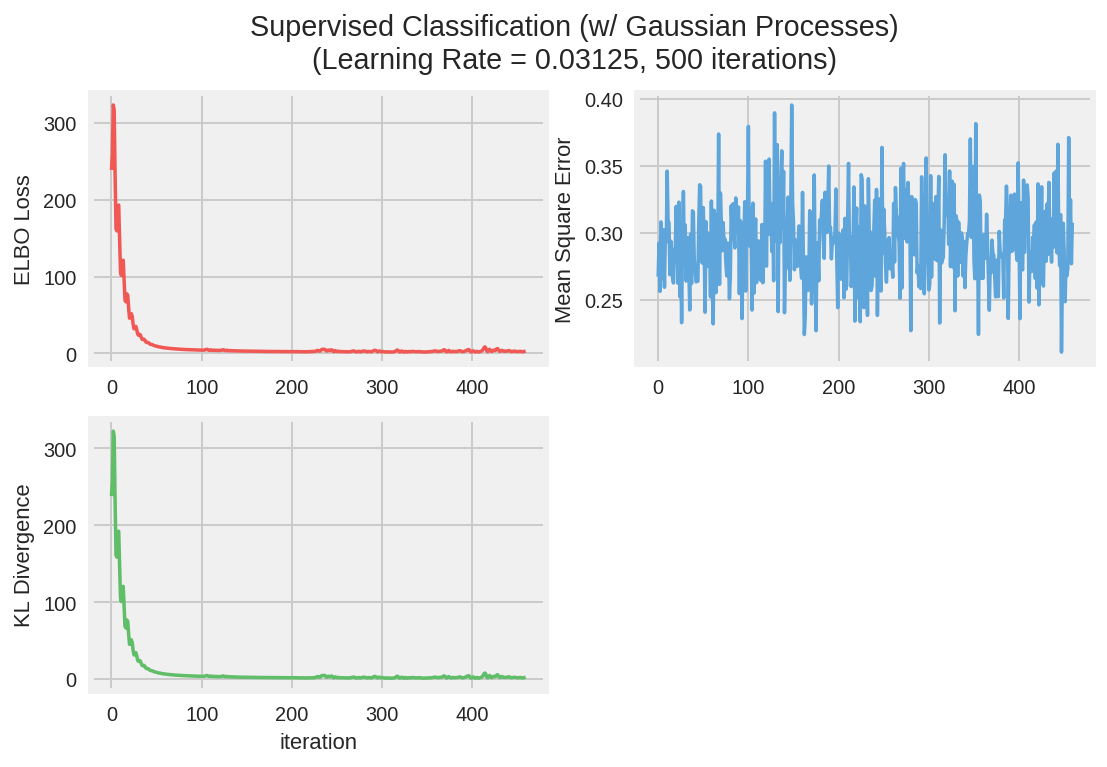

In [0]:
import matplotlib.pyplot as plt

plt.subplot(2, 2, 1)
#plt.semilogy(elbo_, np.exp(-elbo_/1.0))
plt.plot(elbo_[40:], TFColor[0])
plt.ylabel('ELBO Loss')

plt.subplot(2, 2, 2)
plt.plot(mse_[40:], TFColor[3])
plt.ylabel('Mean Square Error')

plt.subplot(2, 2, 3)
plt.plot(kl_[40:], TFColor[2])
plt.ylabel('KL Divergence')
plt.xlabel('iteration')

plt.suptitle('Supervised Classification (w/ Gaussian Processes)\n(Learning Rate = {}, {} iterations)'.format(learning_rate, num_steps))

plt.show()

## Reference

[1] Rasmussen, C. E., & Williams, C. (2006). [Gaussian processes for machine learning](http://www.newton.ac.uk/files/seminar/20070809140015001-150844.pdf). MIT Press.

[2] [Supervised Classification](http://edwardlib.org/tutorials/supervised-classification)